# Data Pipeline: Pipeline of Temperatures and Wildfires

## 1. Import necessary libraries

___

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql
import numpy as np
import datetime as dt
import folium
from IPython import display
from ipywidgets import widgets, interact
from math import ceil

%matplotlib inline

## 2. Import necessary data

___

In [62]:
# extracting temperatures from the csv dataset
climate_country = pd.read_csv('data/climate_change/GlobalLandTemperaturesByCountry.csv')
temperatures = pd.DataFrame(climate_country)

# extracting data from wildfires from the sql dataset (this takes some time)
conn = sql.connect('data/us_wildfires/FPA_FOD_20170508.sqlite')
c = conn.cursor()
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
query = conn.execute("SELECT * From 'Fires'")
cols = [column[0] for column in query.description]
wildfire = pd.DataFrame.from_records(data = query.fetchall(), columns=cols)

## 3. Data wrangling

___

In [65]:
# let's take a look at those dataframes

print(wildfire.shape)
print(temperatures.shape)

(1880465, 39)
(577462, 4)


In [66]:
# exploring data from the temperatures dataset: data types

climate_country.dtypes

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
Country                           object
dtype: object

In [30]:
# exploring data from the temperatures dataset: general outline
# dt is the date, expressed in 'yyyy-mm-dd' format. there is the daily av. temp. and uncertainty, and country.
# many values seem to be missing from the tem peratures, wich might be a problem only from early days.

climate_country.head()

dt  AverageTemperature  AverageTemperatureUncertainty Country
0  1743-11-01  4.384               2.294                          Åland 
1  1743-12-01 NaN                 NaN                             Åland 
2  1744-01-01 NaN                 NaN                             Åland 
3  1744-02-01 NaN                 NaN                             Åland 
4  1744-03-01 NaN                 NaN                             Åland

In [31]:
# printing the countries attribute, to search for the United States exact call

print(climate_country['Country'].nunique())
print(climate_country['Country'].unique())

array(['Åland', 'Afghanistan', 'Africa', 'Albania', 'Algeria',
       'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica',
       'Antigua And Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Asia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Baker Island', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bhutan', 'Bolivia',
       'Bonaire, Saint Eustatius And Saba', 'Bosnia And Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands', 'Bulgaria',
       'Burkina Faso', 'Burma', 'Burundi', "Côte D'Ivoire", 'Cambodia',
       'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Chile', 'China',
       'Christmas Island', 'Colombia', 'Comoros',
       'Congo (Democratic Republic Of The)', 'Congo', 'Costa Rica',
       'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czech Republic',
       'Denmark (Europe)', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecu

In [32]:
# extracting actual records from temperatures in the United States

climate_rec = climate_country.dropna(axis=0)
climate_us = climate_country[(climate_country['Country']=='United States')]

In [33]:
# exploring data from the wildfires dataset

wildfire.dtypes

OBJECTID                      int64  
FOD_ID                        int64  
FPA_ID                        object 
SOURCE_SYSTEM_TYPE            object 
SOURCE_SYSTEM                 object 
NWCG_REPORTING_AGENCY         object 
NWCG_REPORTING_UNIT_ID        object 
NWCG_REPORTING_UNIT_NAME      object 
SOURCE_REPORTING_UNIT         object 
SOURCE_REPORTING_UNIT_NAME    object 
LOCAL_FIRE_REPORT_ID          object 
LOCAL_INCIDENT_ID             object 
FIRE_CODE                     object 
FIRE_NAME                     object 
ICS_209_INCIDENT_NUMBER       object 
ICS_209_NAME                  object 
MTBS_ID                       object 
MTBS_FIRE_NAME                object 
COMPLEX_NAME                  object 
FIRE_YEAR                     int64  
DISCOVERY_DATE                float64
DISCOVERY_DOY                 int64  
DISCOVERY_TIME                object 
STAT_CAUSE_CODE               float64
STAT_CAUSE_DESCR              object 
CONT_DATE                     float64
CONT_DOY    

In [34]:
# selecting useful columns from the temperatures dataset
# might have columns with very low variability, and in so relevance, and columns with very high correlation.
# we can see from this that, what might interest us, is FIRE_YEAR, DISCOVERY_DOY, LATITUDE, LONGITUDE and OBJECTID

pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth',-1)
pd.set_option('display.width',None)
wildfire.head(15)

OBJECTID  FOD_ID      FPA_ID SOURCE_SYSTEM_TYPE SOURCE_SYSTEM  \
0   1         1       FS-1418826  FED                FS-FIRESTAT    
1   2         2       FS-1418827  FED                FS-FIRESTAT    
2   3         3       FS-1418835  FED                FS-FIRESTAT    
3   4         4       FS-1418845  FED                FS-FIRESTAT    
4   5         5       FS-1418847  FED                FS-FIRESTAT    
5   6         6       FS-1418849  FED                FS-FIRESTAT    
6   7         7       FS-1418851  FED                FS-FIRESTAT    
7   8         8       FS-1418854  FED                FS-FIRESTAT    
8   9         9       FS-1418856  FED                FS-FIRESTAT    
9   10        10      FS-1418859  FED                FS-FIRESTAT    
10  11        11      FS-1418861  FED                FS-FIRESTAT    
11  12        12      FS-1418863  FED                FS-FIRESTAT    
12  13        13      FS-1418865  FED                FS-FIRESTAT    
13  14        14      FS-1418872  FED                FS-FIRESTAT    
14  15        15      FS-1418874  FED                FS-FIRESTAT    

   NWCG_REPORTING_AGENCY NWCG_REPORTING_UNIT_ID  \
0   FS                    USCAPNF                 
1   FS                    USCAENF                 
2   FS                    USCAENF                 
3   FS                    USCAENF                 
4   FS                    USCAENF                 
5   FS                    USCAENF                 
6   FS                    USCAENF                 
7   FS                    USCASHF                 
8   FS                    USCASHF                 
9   FS                    USCAENF                 
10  FS                    USCAENF                 
11  FS                    USCAENF                 
12  FS                    USCAENF                 
13  FS                    USCAENF                 
14  FS                    USCAENF                 

          NWCG_REPORTING_UNIT_NAME SOURCE_REPORTING_UNIT  \
0   Plumas National Forest          0511                   
1   Eldorado National Forest        0503                   
2   Eldorado National Forest        0503                   
3   Eldorado National Forest        0503                   
4   Eldorado National Forest        0503                   
5   Eldorado National Forest        0503                   
6   Eldorado National Forest        0503                   
7   Shasta-Trinity National Forest  0514                   
8   Shasta-Trinity National Forest  0514                   
9   Eldorado National Forest        0503                   
10  Eldorado National Forest        0503                   
11  Eldorado National Forest        0503                   
12  Eldorado National Forest        0503                   
13  Eldorado National Forest        0503                   
14  Eldorado National Forest        0503                   

        SOURCE_REPORTING_UNIT_NAME LOCAL_FIRE_REPORT_ID LOCAL_INCIDENT_ID  \
0   Plumas National Forest          1                    PNF-47             
1   Eldorado National Forest        13                   13                 
2   Eldorado National Forest        27                   021                
3   Eldorado National Forest        43                   6                  
4   Eldorado National Forest        44                   7                  
5   Eldorado National Forest        54                   8                  
6   Eldorado National Forest        58                   9                  
7   Shasta-Trinity National Forest  3                    02                 
8   Shasta-Trinity National Forest  5                    03                 
9   Eldorado National Forest        61                   10                 
10  Eldorado National Forest        64                   11                 
11  Eldorado National Forest        71                   14                 
12  Eldorado National Forest        91                   26                 
13  Eldorado National Forest        99     

In [35]:
"""let's see if there is any difference between OBJECT_ID and FOD_ID, and if there is a difference,
wich one should be chosen."""

wildfire['OBJECTID'].nunique()
wildfire['FOD_ID'].nunique()
len(wildfire['OBJECTID'])

# conclusion: they both have only unique values

1880465

In [36]:
# removing columns with low variance from wildfires dataset
# that resulted in an empty list

lo_var = []

for col in wildfire._get_numeric_data():
    mini = min(wildfire[col])
    ninety_perc = np.percentile(wildfire[col],90)
    if ninety_perc == mini:
        lo_var.append(col)

print(lo_var)

[]


In [37]:
# selecting columns with that would also be useful

firedata = wildfire[['OBJECTID','FIRE_YEAR', 'DISCOVERY_DOY', 'LATITUDE', 'LONGITUDE','NWCG_REPORTING_UNIT_NAME','STAT_CAUSE_DESCR','FIRE_SIZE']]
firedata.head()

OBJECTID  FIRE_YEAR  DISCOVERY_DOY   LATITUDE   LONGITUDE  \
0  1         2005       33             40.036944 -121.005833   
1  2         2004       133            38.933056 -120.404444   
2  3         2004       152            38.984167 -120.735556   
3  4         2004       180            38.559167 -119.913333   
4  5         2004       180            38.559167 -119.933056   

   NWCG_REPORTING_UNIT_NAME STAT_CAUSE_DESCR  FIRE_SIZE  
0  Plumas National Forest    Miscellaneous    0.10       
1  Eldorado National Forest  Lightning        0.25       
2  Eldorado National Forest  Debris Burning   0.10       
3  Eldorado National Forest  Lightning        0.10       
4  Eldorado National Forest  Lightning        0.10

In [38]:
# creating a column of equivalent month from the 'DISCOVERY_DOY' column in the firedata dataset

def dtm(days):
    """
    transforms days from a Julian year into the equivalent month
    
    only argument: number of days
    returns: month of equivalence as integer
    """
    monthd = [31,28,31,30,31,30,31,31,30,31,30,31]
    monthsum = []
    
    for i in range(len(monthd)):
        monthsum.append(sum(monthd[:i+1]))
    
    for i in monthsum:
        if days<=i:
            return int(monthsum.index(i)+1)

firedata['MONTH'] = firedata['DISCOVERY_DOY'].apply(dtm)
firedata = firedata.drop('DISCOVERY_DOY',axis=1)
firedata.head()

/home/nacholez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


OBJECTID  FIRE_YEAR   LATITUDE   LONGITUDE  NWCG_REPORTING_UNIT_NAME  \
0  1         2005       40.036944 -121.005833  Plumas National Forest     
1  2         2004       38.933056 -120.404444  Eldorado National Forest   
2  3         2004       38.984167 -120.735556  Eldorado National Forest   
3  4         2004       38.559167 -119.913333  Eldorado National Forest   
4  5         2004       38.559167 -119.933056  Eldorado National Forest   

  STAT_CAUSE_DESCR  FIRE_SIZE  MONTH  
0  Miscellaneous    0.10       2.0    
1  Lightning        0.25       5.0    
2  Debris Burning   0.10       6.0    
3  Lightning        0.10       6.0    
4  Lightning        0.10       6.0

In [39]:
# cleaning and setting values from the month column in firedata

firedata = firedata.replace([np.inf,-np.inf],np.nan) # dropping infinite values
firedata = firedata.dropna(axis=0)
firedata['MONTH'] = firedata['MONTH'].astype('int')
firedata.dtypes

OBJECTID                    int64  
FIRE_YEAR                   int64  
LATITUDE                    float64
LONGITUDE                   float64
NWCG_REPORTING_UNIT_NAME    object 
STAT_CAUSE_DESCR            object 
FIRE_SIZE                   float64
MONTH                       int64  
dtype: object

In [40]:
# creating a column of month and year in the climate_us dataset

climate_us['Year'] = pd.DatetimeIndex(climate_us['dt']).year
climate_us['Month'] = pd.DatetimeIndex(climate_us['dt']).month
climate_us.head()

/home/nacholez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/nacholez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


dt  AverageTemperature  AverageTemperatureUncertainty  \
554880  1768-09-01  15.420              2.880                           
554881  1768-10-01  8.162               3.386                           
554882  1768-11-01  1.591               3.783                           
554883  1768-12-01 -2.882               4.979                           
554884  1769-01-01 -3.952               4.856                           

              Country  Year  Month  
554880  United States  1768  9      
554881  United States  1768  10     
554882  United States  1768  11     
554883  United States  1768  12     
554884  United States  1769  1

In [41]:
# dividing the temperatures into two datasets: the early values, and the ones equivalent to the wildfires dataset

climate_rl = climate_us.loc[(climate_us['Year'] > climate_us['Year'].min()) & (climate_us['Year'] < climate_us['Year'].min()+12)]
climate_eq = climate_us.loc[(climate_us['Year'] >= firedata['FIRE_YEAR'].min()) & (climate_us['Year'] <= firedata['FIRE_YEAR'].max())]

In [42]:
# creating a merging key for the main datasets

climate_eq['Date'] = climate_eq.apply(lambda row: dt.datetime(row['Year'],row['Month'],1), axis=1)
firedata['Date'] = firedata.apply(lambda row: dt.datetime(int(row['FIRE_YEAR']),int(row['MONTH']),1), axis=1)

/home/nacholez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
# merging the datasets through the date key

temp_fire = pd.merge(firedata,climate_eq,on='Date',how='inner')
temp_fire.head()

OBJECTID  FIRE_YEAR   LATITUDE   LONGITUDE  \
0  1         2005       40.036944 -121.005833   
1  32        2005       43.995556 -121.414167   
2  39        2005       35.931667 -81.716667    
3  40        2005       36.001667 -81.590000    
4  49        2005       43.725278 -121.574167   

             NWCG_REPORTING_UNIT_NAME STAT_CAUSE_DESCR  FIRE_SIZE  MONTH  \
0  Plumas National Forest              Miscellaneous    0.1        2       
1  Deschutes National Forest           Campfire         0.1        2       
2  National Forests in North Carolina  Arson            0.1        2       
3  National Forests in North Carolina  Debris Burning   125.0      2       
4  Deschutes National Forest           Campfire         0.1        2       

        Date          dt  AverageTemperature  AverageTemperatureUncertainty  \
0 2005-02-01  2005-02-01  0.408               0.16                            
1 2005-02-01  2005-02-01  0.408               0.16                            
2 2005-02-01  2005-02-01  0.408               0.16                            
3 2005-02-01  2005-02-01  0.408               0.16                            
4 2005-02-01  2005-02-01  0.408               0.16                            

         Country  Year  Month  
0  United States  2005  2      
1  United States  2005  2      
2  United States  2005  2      
3  United States  2005  2      
4  United States  2005  2

In [47]:
# removing unnecessary columns

temp_fire = temp_fire.drop(['OBJECTID','FIRE_YEAR','MONTH','Country','dt'],axis=1)
temp_fire.rename(columns={'AverageTemperature':'current_av_temperature','AverageTemperatureUncertainty':'current_uncertainty'},inplace=True)
temp_fire.head()

LATITUDE   LONGITUDE            NWCG_REPORTING_UNIT_NAME STAT_CAUSE_DESCR  \
0  40.036944 -121.005833  Plumas National Forest              Miscellaneous     
1  43.995556 -121.414167  Deschutes National Forest           Campfire          
2  35.931667 -81.716667   National Forests in North Carolina  Arson             
3  36.001667 -81.590000   National Forests in North Carolina  Debris Burning    
4  43.725278 -121.574167  Deschutes National Forest           Campfire          

   FIRE_SIZE       Date  current_av_temperature  current_uncertainty  Year  \
0  0.1       2005-02-01  0.408                   0.16                 2005   
1  0.1       2005-02-01  0.408                   0.16                 2005   
2  0.1       2005-02-01  0.408                   0.16                 2005   
3  125.0     2005-02-01  0.408                   0.16                 2005   
4  0.1       2005-02-01  0.408                   0.16                 2005   

   Month  
0  2      
1  2      
2  2      
3  2      
4  2

In [48]:
# create a monthly baseline of temperature changes in the USA from the 11 first recorded years

early_av = climate_rl.groupby('Month').mean().reset_index()
early_av.set_index([pd.Index([1,2,3,4,5,6,7,8,9,10,11,12])])
early_av['Month'] = [1,2,3,4,5,6,7,8,9,10,11,12]
early_av = early_av.drop(['Year'],axis=1)
early_av.rename(columns={'AverageTemperature':'early_av_temperature','AverageTemperatureUncertainty':'early_uncertainty'},inplace=True)
early_av

Month  early_av_temperature  early_uncertainty
0   1     -3.404500              3.90150          
1   2     -0.439400              3.78680          
2   3      2.876600              3.01600          
3   4      7.399000              2.42750          
4   5      14.437500             3.04400          
5   6      18.554200             2.78420          
6   7      20.952500             2.31450          
7   8      20.626250             2.49475          
8   9      15.116667             2.45700          
9   10     8.619200              2.92100          
10  11     2.221600              3.62600          
11  12    -3.295200              3.11860

In [49]:
# merge the new column, making relative calculations possible

temp_fire = pd.merge(temp_fire,early_av,on='Month')

In [50]:
# creating one last column: 'rel_tem', as a measure of the temperature increase, relative to the baseline

temp_fire['rel_temperature'] = temp_fire['current_av_temperature']-temp_fire['early_av_temperature']
temp_fire.head()

LATITUDE   LONGITUDE            NWCG_REPORTING_UNIT_NAME STAT_CAUSE_DESCR  \
0  40.036944 -121.005833  Plumas National Forest              Miscellaneous     
1  43.995556 -121.414167  Deschutes National Forest           Campfire          
2  35.931667 -81.716667   National Forests in North Carolina  Arson             
3  36.001667 -81.590000   National Forests in North Carolina  Debris Burning    
4  43.725278 -121.574167  Deschutes National Forest           Campfire          

   FIRE_SIZE       Date  current_av_temperature  current_uncertainty  Year  \
0  0.1       2005-02-01  0.408                   0.16                 2005   
1  0.1       2005-02-01  0.408                   0.16                 2005   
2  0.1       2005-02-01  0.408                   0.16                 2005   
3  125.0     2005-02-01  0.408                   0.16                 2005   
4  0.1       2005-02-01  0.408                   0.16                 2005   

   Month  early_av_temperature  early_uncertainty  rel_temperature  
0  2     -0.4394                3.7868             0.8474           
1  2     -0.4394                3.7868             0.8474           
2  2     -0.4394                3.7868             0.8474           
3  2     -0.4394                3.7868             0.8474           
4  2     -0.4394                3.7868             0.8474

In [51]:
# saving final dataset in a csv document

temp_fire.to_csv('output/temp_fire.csv')

## 4. Data Analysis

___

In [2]:
# reading exported csv, in case the notebook was closed

temp_fire = pd.read_csv('output/temp_fire.csv')
temp_fire.drop('Unnamed: 0',axis=1,inplace=True)
temp_fire.sort_values(by=['Year','Month'],inplace=True)

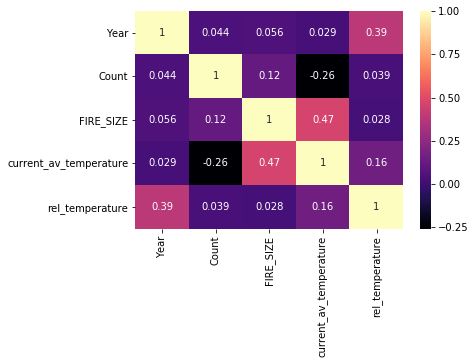

In [3]:
# correlation between count of monthly fires and fire sizes, and temperatures (baseline and present)

new_df = pd.DataFrame
new_df = temp_fire[['Year','FIRE_SIZE','STAT_CAUSE_DESCR']].groupby(['Year','STAT_CAUSE_DESCR']).count().reset_index()
new_df.head()
new_df.rename({'FIRE_SIZE':'Count'},axis=1,inplace=True)
new_df = new_df.merge(temp_fire[['Year','FIRE_SIZE','current_av_temperature','rel_temperature','STAT_CAUSE_DESCR']].groupby(['Year','STAT_CAUSE_DESCR']).mean().reset_index(),on=['Year','STAT_CAUSE_DESCR'])
sns.heatmap(new_df.corr(),cmap='magma',annot=True);

# weak correlation between fire sizes and number of fires
# average negative correlation between number of fires and average temperatures
# strongest correlation between temperature increase and year

In [7]:
# let's take a look at our data


print('the number of national wildfire reporting groups is',temp_fire['NWCG_REPORTING_UNIT_NAME'].nunique())
print('the maximum reported latitude is',temp_fire['LATITUDE'].max())
print('the minimum reported latitude is',temp_fire['LATITUDE'].min())
print('the maximum reported longitude is',temp_fire['LONGITUDE'].max())
print('the minimum reported longitude is',temp_fire['LONGITUDE'].min())
print('the maximum reported fire size (in acres) was',temp_fire['FIRE_SIZE'].max())
print('the minimum reported fire size (in acres) was',temp_fire['FIRE_SIZE'].min())
print('the average reported fire size (in acres) was',temp_fire['FIRE_SIZE'].mean())
print('the maximum monthly national average temperature was',temp_fire['current_av_temperature'].max())
print('the minimum monthly national average temperature was',temp_fire['current_av_temperature'].min())
print('the maximum monthly national average temperature increase was',temp_fire['rel_temperature'].max())
print('the maximum monthly national average temperature decrease was',temp_fire['rel_temperature'].min())
print('the average monthly national average temperature variation from standpoint was',temp_fire['rel_temperature'].mean())
print('the number of reported fire causes is',temp_fire['STAT_CAUSE_DESCR'].nunique())
print('earliest data',temp_fire['Date'].min())
print('latest data',temp_fire['Date'].max())
print('those fire causes are',temp_fire['STAT_CAUSE_DESCR'].unique())

the number of national wildfire reporting groups is 1575
the maximum reported latitude is 70.1381
the minimum reported latitude is 17.93972222
the maximum reported longitude is -65.25694444
the minimum reported longitude is -178.8026
the maximum reported fire size (in acres) was 606945.0
the minimum reported fire size (in acres) was 9e-05
the average reported fire size (in acres) was 72.94718615553683
the maximum monthly national average temperature was 23.00800000000001
the minimum monthly national average temperature was -4.316000000000002
the maximum monthly national average temperature increase was 3.267333333333335
the maximum monthly national average temperature decrease was -2.1826
the average monthly national average temperature variation from standpoint was 0.8734214292869618
the number of reported fire causes is 13
earliest data 1992-01-01
latest data 2013-09-01
those fire causes are ['Smoking' 'Miscellaneous' 'Arson' 'Campfire' 'Debris Burning' 'Lightning'
 'Equipment Use' '

In [340]:
# which were the biggest wildfires?

temp_fire[['NWCG_REPORTING_UNIT_NAME','STAT_CAUSE_DESCR','FIRE_SIZE','Date','current_av_temperature']].sort_values('FIRE_SIZE').tail(10)

NWCG_REPORTING_UNIT_NAME   STAT_CAUSE_DESCR  FIRE_SIZE  \
1359317              Winnemucca District Office          Lightning   461047.0   
289793                      Alaska State Office          Lightning   463994.0   
683381   Lake Meredith National Recreation Area  Missing/Undefined   479549.0   
442346                      Alaska State Office          Lightning   483280.0   
460041     Rogue River-Siskiyou National Forest          Lightning   499945.0   
332574                      Alaska State Office          Lightning   517078.0   
289736                      Alaska State Office          Lightning   537627.0   
267893        Apache-Sitgreaves National Forest           Campfire   538049.0   
642682                            Vale District          Lightning   558198.3   
368511                      Alaska State Office          Lightning   606945.0   

               Date  current_av_temperature  
1359317  2012-08-01                  21.422  
289793   2004-06-01                  19.228  
683381   2006-03-01                   2.794  
442346   2004-07-01                  21.663  
460041   2002-07-01                  22.675  
332574   2009-06-01                  18.962  
289736   2004-06-01                  19.228  
267893   2011-05-01                  13.759  
642682   2012-07-01                  23.008  
368511   1997-06-01                  19.042

In [75]:
temp_fire.STAT_CAUSE_DESCR

0              Miscellaneous
1                   Campfire
2                      Arson
3             Debris Burning
4                   Campfire
                 ...        
1729609    Missing/Undefined
1729610    Missing/Undefined
1729611              Smoking
1729612              Smoking
1729613    Missing/Undefined
Name: STAT_CAUSE_DESCR, Length: 1729614, dtype: object

In [106]:
new_df.tail()

Year   STAT_CAUSE_DESCR  Count  FIRE_SIZE  current_av_temperature  \
281  2013  Missing/Undefined   3766  52.843882               14.325303   
282  2013          Powerline    588  12.116015               11.491197   
283  2013           Railroad    393   8.744224               12.536481   
284  2013            Smoking   1195   2.211096               11.800954   
285  2013          Structure    194   3.824227                9.702129   

     rel_temperature  
281         0.648449  
282         0.391026  
283         0.185190  
284         0.339751  
285         0.222954

In [45]:
# correlation between fire sizes and altitude
# for a spacial ranking, I'ss opt for a the Spearman method

temp_fire[['LATITUDE','LONGITUDE','FIRE_SIZE']].corr(method='spearman')

# there seems to be a sensible but weak negative correlation with latitude, and almost none with longitude

LATITUDE  LONGITUDE  FIRE_SIZE
LATITUDE   1.000000  -0.293453  -0.264935
LONGITUDE -0.293453   1.000000   0.149849
FIRE_SIZE -0.264935   0.149849   1.000000

## 5. Printing of graphs


___

In [188]:
# 

temp_fire.head()

Unnamed: 0   LATITUDE   LONGITUDE            NWCG_REPORTING_UNIT_NAME  \
0           0  40.036944 -121.005833              Plumas National Forest   
1           1  43.995556 -121.414167           Deschutes National Forest   
2           2  35.931667  -81.716667  National Forests in North Carolina   
3           3  36.001667  -81.590000  National Forests in North Carolina   
4           4  43.725278 -121.574167           Deschutes National Forest   

  STAT_CAUSE_DESCR  FIRE_SIZE        Date  current_av_temperature  \
0    Miscellaneous        0.1  2005-02-01                   0.408   
1         Campfire        0.1  2005-02-01                   0.408   
2            Arson        0.1  2005-02-01                   0.408   
3   Debris Burning      125.0  2005-02-01                   0.408   
4         Campfire        0.1  2005-02-01                   0.408   

   current_uncertainty  Year  Month  early_av_temperature  early_uncertainty  \
0                 0.16  2005      2               -0.4394             3.7868   
1                 0.16  2005      2               -0.4394             3.7868   
2                 0.16  2005      2               -0.4394             3.7868   
3                 0.16  2005      2               -0.4394             3.7868   
4                 0.16  2005      2               -0.4394             3.7868   

   rel_temperature  
0           0.8474  
1           0.8474  
2           0.8474  
3           0.8474  
4           0.8474

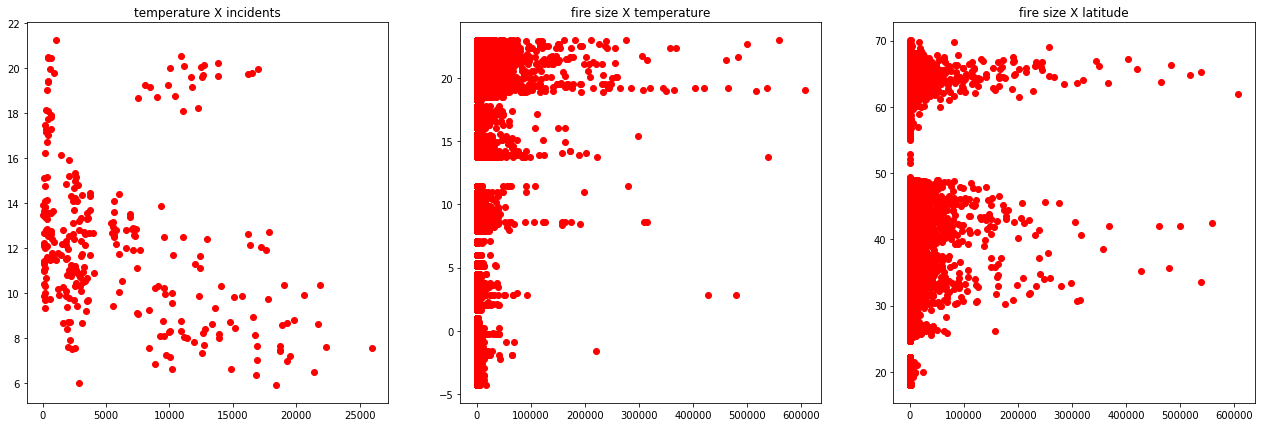

In [11]:
# THIS scatterplot between average teperatures and number of monthly fires

fig, axs = plt.subplots(1,3,figsize=(22,7),sharey=False)

axs[0].scatter('Count','current_av_temperature', data=new_df,c='r')
axs[1].scatter('FIRE_SIZE','current_av_temperature', data=temp_fire,c='r')
axs[2].scatter('FIRE_SIZE','LATITUDE', data=temp_fire,c='r')
axs[0].set_title('temperature X incidents')
axs[1].set_title('fire size X temperature')
axs[2].set_title('fire size X latitude');

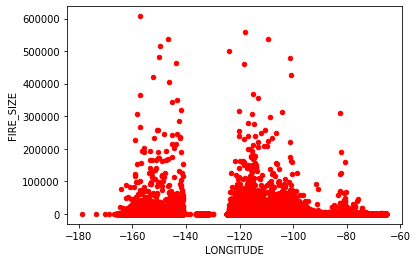

In [58]:
# scatterplot of fire incidents by fire size and latitude

temp_fire.plot.scatter('LONGITUDE','FIRE_SIZE',c='r');

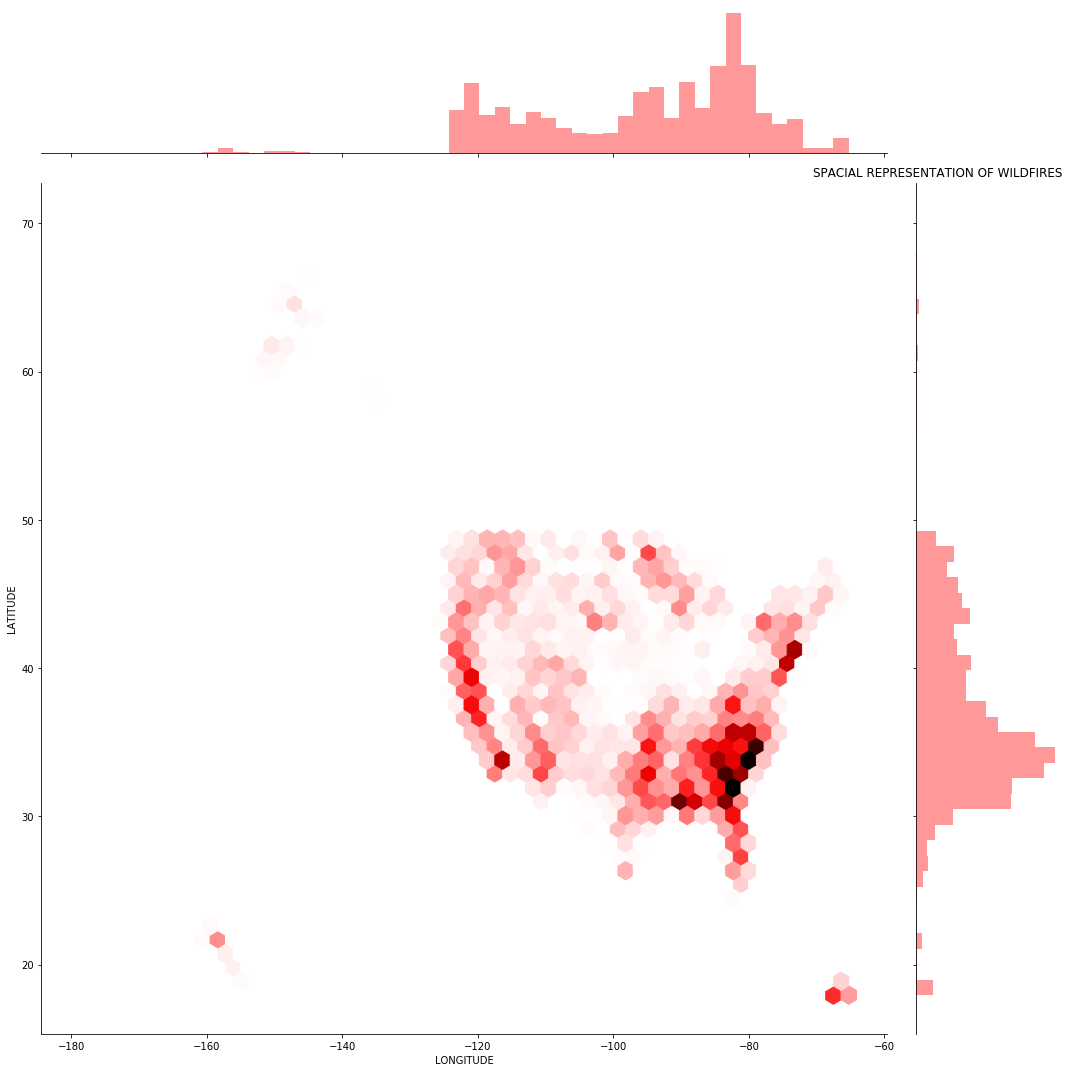

In [28]:
# plot those now as a sns.jointplot

sns.jointplot(x='LONGITUDE',
              y='LATITUDE',
              data=temp_fire,
              kind='hex',
              color='r',
              height=15)
plt.title('SPACIAL REPRESENTATION OF WILDFIRES');

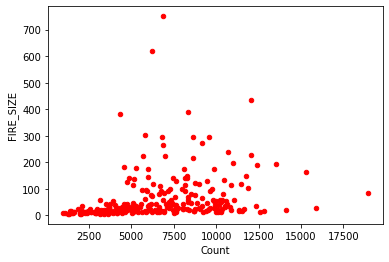

In [165]:
# scatterplot between number of fires and fire sizes


new_df.plot.scatter('Count','FIRE_SIZE',c='r');

In [4]:
# defining function to call 1 in 1000 largest fire incidents into map

def plotmonth(month,year):
    data = temp_fire[temp_fire.Year == year]
    data = data[data.Month == month]
    data = data.sort_values('FIRE_SIZE').tail(ceil(len(data)/1000))
    usmap = folium.Map(location=[50,-140],zoom_start=3)
    
    for fire in data.itertuples():
        folium.Marker(location=[fire.LATITUDE,fire.LONGITUDE],
                  popup='Cause: <strong>{}</strong>'.format(fire.STAT_CAUSE_DESCR),
                  icon=folium.Icon(icon='fire',color='red'),
                  tooltip=fire.NWCG_REPORTING_UNIT_NAME).add_to(usmap)
        
    return usmap

In [5]:
# map with fires along time, described by cause and reporting unit

interact(plotmonth,
         year=widgets.IntSlider(description='Year',
                                        min=temp_fire['Year'].min(),
                                        max=temp_fire['Year'].max(),
                                        step=1,
                                        value=temp_fire['Year'].min()),
         month=widgets.IntSlider(description='Month',
                                        min=temp_fire['Month'].min(),
                                        max=temp_fire['Month'].max(),
                                        step=1,
                                        value=temp_fire['Month'].min()));

interactive(children=(IntSlider(value=1, description='Month', max=12, min=1), IntSlider(value=1992, descriptio…

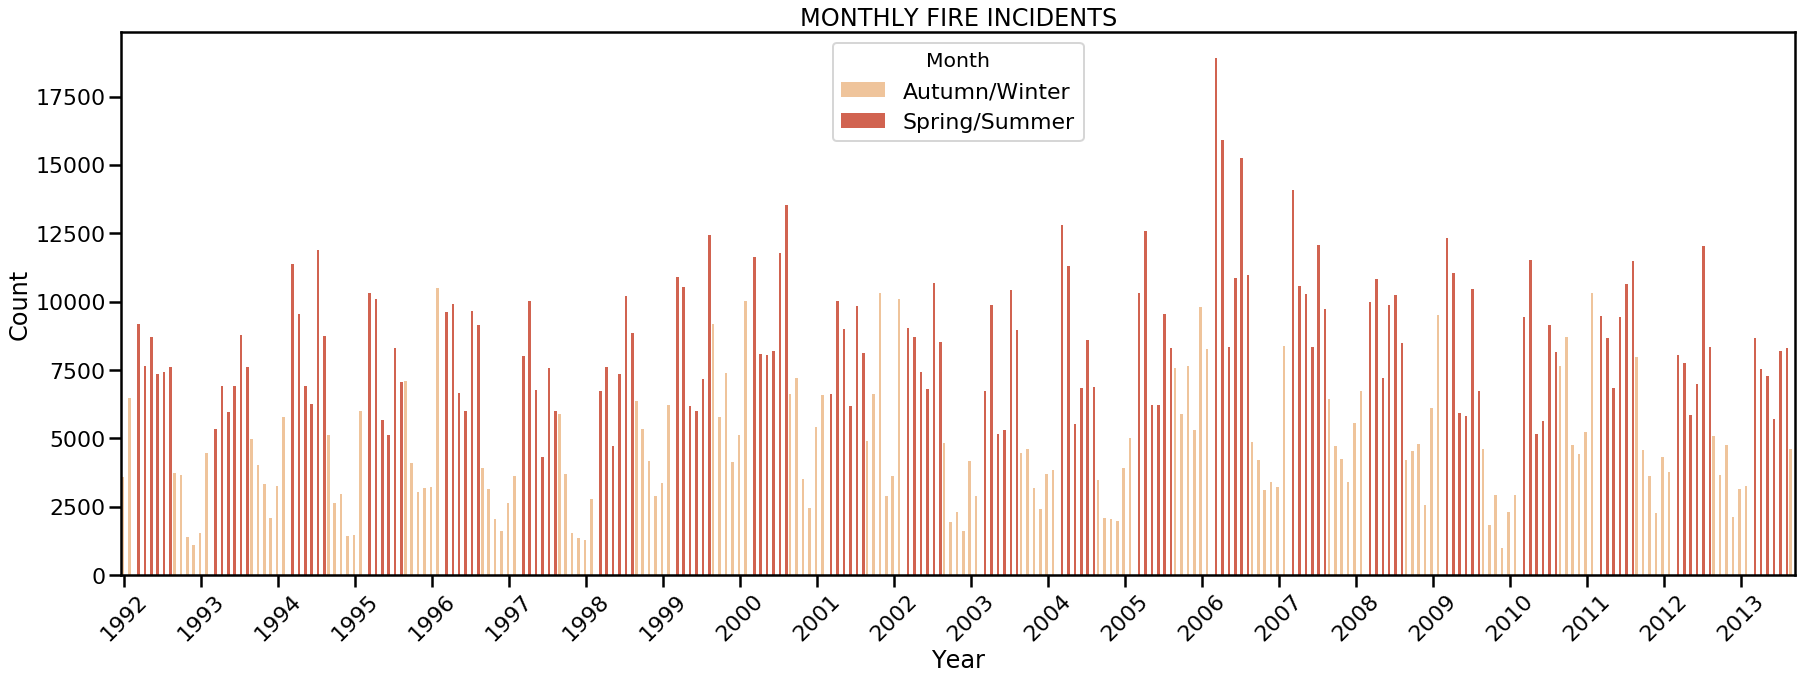

In [15]:
# temperatures in time with relative temperatures, along fire counts (bars)

plt.figure(figsize=(30,10))
sns.set_context('poster')
colors = temp_fire.Month.map(lambda x: "Spring/Summer" if x in list(range(3,9)) else "Autumn/Winter")
sns.countplot(x='Date',
              data=temp_fire,
              hue=colors,
              palette='OrRd',
              ).set_title('MONTHLY FIRE INCIDENTS')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(12*np.arange(len(temp_fire.Year.unique())),tuple(temp_fire.Year.unique()), rotation=45);

In [56]:
new_df.head()

Year STAT_CAUSE_DESCR  Count  FIRE_SIZE  current_av_temperature  \
0  1992            Arson  11153  23.962908                8.036319   
1  1992         Campfire   2570  10.479276               14.241684   
2  1992         Children   2913  17.470997               10.721066   
3  1992   Debris Burning  12726  12.116623                7.714247   
4  1992    Equipment Use   5630  24.183606               12.512860   

   rel_temperature  
0         0.709693  
1         0.040815  
2         0.441100  
3         0.770135  
4         0.194698

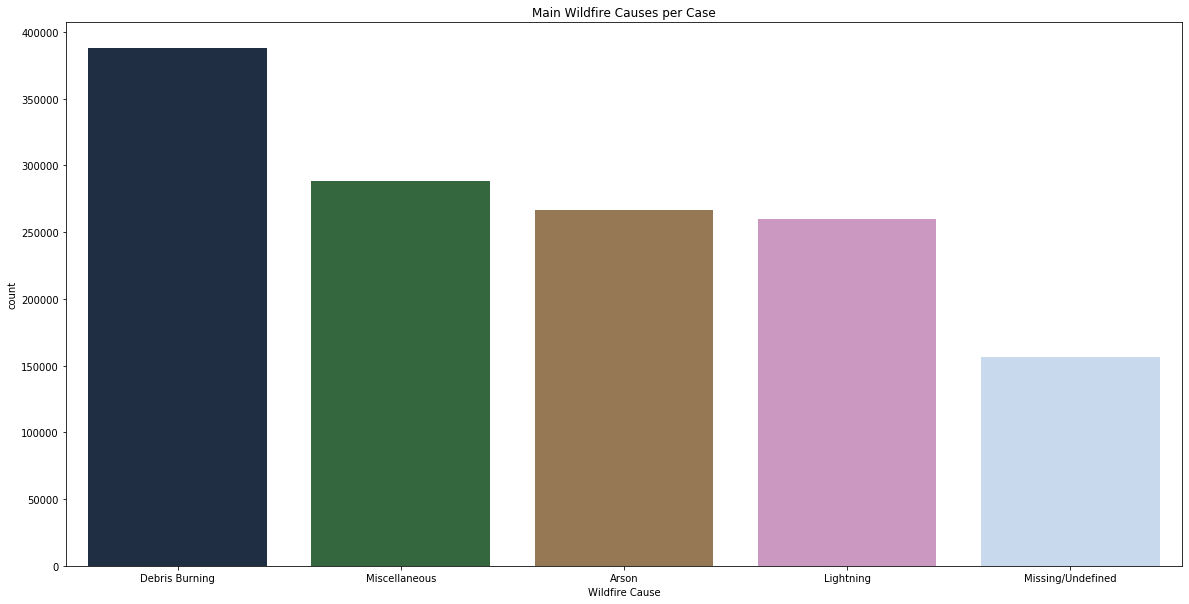

In [6]:
# main causes of fire incidents

plt.figure(figsize=(20,10))
sns.countplot(x='STAT_CAUSE_DESCR',
              data=temp_fire,
              palette='cubehelix',
              order=temp_fire['STAT_CAUSE_DESCR'].value_counts().head(5).index).set_title('Main Wildfire Causes per Case')
plt.xlabel('Wildfire Cause');data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABKUAAAJcCAYAAAAo8BegAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8li6FKAAAgAElEQVR4nOzde7hvVXkf+u8rW9REEZAdioDiUZoEbUXdQXLMrdJwMRdoghZj446holF7kidpj5qeE43GRp+nCUcTxZiCglWRmhhpgkWCVhtThG3ECxrD9lYgKjuAeItY8D1//MbWn9u1F4vLGnsFPp/nmc+a851jzDHmj/3XlzHnrO4OAAAAAMx0jz09AQAAAADufoRSAAAAAEwnlAIAAABgOqEUAAAAANMJpQAAAACYTigFAAAAwHRCKQBgw6iqB1XVl6tqrwljPaWq3rF03FX1sN20/YWq+oul48dV1ZVjridV1duraut6zxkA4K5EKAUA3Cmq6tNV9fWqOmCX+gdG4HPYrV2ju/9Xd9+3u2+5HeN/vKr+5dLx48a4u9a+VFWbuvsN3X3sbR1neFGS3x9z/ZPuPqG7z76d1/oOVbV3Vb1wBF9fGb/tWWv5De8Oquq4qnrP+G+5o6reXVU/vafnBQDcNkIpAODO9KkkT955UFX/JMl3TRr7PUl+ZOn4R5L89Qq1/9ndN9/BsR6c5Iq1NKyqTbfj+m9J8tNJfi7J/ZM8Msn7kxxzO671D9ZKK+aq6uQk/yXJOUkOSXJgkt9I8lNzZwcA3FFCKQDgzvT6JE9dOt6aRXjwTVX1E2P11Ber6qqqeuHSucPG6qZN4/i/V9WLq+q9Y1XMO3ZdibVk11Dqh5O8bIXae8a1v+2RvF3m+ICqOn/M8dIkD10694kk/0eS/zoe37vXmOe/Xrrue6vq9Kq6LskLR/0Xq+pjVXVDVV1YVQ/ezdj/PMmPJzmxuy/r7pu7+8bufmV3nznaPG1c60tV9cmqesZS/++4r+VHE6vqCVX10dH3mqr6t0vtfrKqLq+qL1TVX1bVP10699zR/ktjVdqKAVlVva6qXl1VF422716+16r6vnHu+nGdJ+3S94yquqCqvpLkn+1y7Uryu0le3N3/afwu3+jud3f300ebh1bVO6vquqr6u6p6Q1Xte2v3UVX3qKrnVdUnRt/zqmr/le4RALhzCKUAgDvTJUn2qarvH6tcTknyn3dp85Usgqt9k/xEkl+qqpNWuebPJXlaku9JsneSf7ubdu9J8vCq2r+q7pFkS5I3J9l3qfa40e7WvDLJ15IclOQXx5Yk6e6HJvlfSX5qPL530wr9H5vkk1ms4nlJVZ2Y5NeT/EySzUn+R5I37Wbsf57k0u6+apX5XZvkJ5Psk8Vvc3pVPXoN95UkZyZ5RnffL8kjkrwzSarqUUnOSvKMJA9I8gdJzh+h2/cmeU6SHxj9jkvy6VXGeEqSFyc5IMnlSd4wxvjuJBcleWMW/z1PSfKqqjpiqe/PJXlJkvsl2TU0/N4kh2axkmx3KslvJ3lgku8f7V84xl/tPv5NkpOS/Ojoe0MW/w4AgHUilAIA7mw7V0v9eJKPJblm+WR3//fu/vBY4fKhLMKZH13leq/t7r/p7r9Pcl6SI1dq1N2fySIs+uEsHne7cvR571Jt7yTvW23yI0z72SS/0d1f6e6PJLmt74v62+7+vbHK6e+TPDPJb3f3x8ajg/8hyZG7WS31gCSfXe3i3f1n3f2JXnh3kneMe1yL/53kiKrap7tv6O6/GvXTkvxBd7+vu28Z78i6KcnRSW5Jcq/R757d/enu/sQqY/xZd79nBHb/PskPVtWhWQRpn+7u147f5gNJ/ijJE5f6vq273zv+fXxtl+s+YPzd7e/T3du7+6Luvqm7d2Sxsmrnv6/V7uOZSf59d1895v3CJCffzscvAYA1EEoBAHe212ex2uUXssuje0lSVY+tqneNF1TfmEUYsLtH8pLkc0v7X01y31Xa7nyE70eyWI2ULFbb7KxdupuVTcs2J9mUZHml0mdupc+udl3l9OAkLx+PxX0hyfVZrOg5eIW+12WxQmu3quqEqrpkPAL3hSRPyOq/4bKfHe0/Mx6t+8GlOf7azjmO6x6a5IHdvT3Jr2QR1FxbVedW1QNXGeOb99/dX87ifh84xnjsLmM8Jck/WqnvCq4bf3f7+1TVgWN+11TVF7NYqXfAmMtq9/HgJG9dmtfHsgixDlxlPgDAHSCUAgDuVGPF0qeyCD7+eIUmb0xyfpJDu/v+SV6dRUBzZ9gZSv1wvhVK/Y+l2loe3duR5OYsApmdHnQb59G7HF+VxSNz+y5t9+nuv1yh758nOaqqDlnpwlV1ryxWF/3HJAd2975JLsi3fsOvZOnl8lW1HPhkvKfqxCwen/uTLFaf7ZzjS3aZ43d195tGvzd29w9lEd50Fu/r2p1v/nZVdd8k+yf52zHGu3cZ477d/UvLU1zluh8f1/jZVdr8h3GNf9Ld+yT5V1n697XKfVyV5IRd5nbv7r4mAMC6EEoBAOvh1CSP7+6vrHDufkmu7+6vVdVRWayqurO8J8mjsgih3jtqH07ykCxemn2roVR335JFmPbCqvqu8b6jrXdwXq9O8vyqeniSVNX9q+qJKzXs7j/P4r1Lb62qx1TVpqq6X1U9s6p+MYtHEO+VEZ5V1QlJjl26xAezeLfWkVV174z3KY1x966qp1TV/bv7fyf5YpJvjNN/mOSZYyVbVdV31+Kl9Perqu+tqsePQOxrSf5+qd9KnlBVP1RVe2fxbqlLxjuy/jTJP66qn6+qe47tB6rq+9fyI3Z3J/nVJP9vLV72vs94QfkPVdVrRrP7Jflykhur6uAk/27p/le7j1dn8f6vB4+2m8e7wACAdSKUAgDudON9R9t2c/pZSV5UVV9K8hv51kqdO2Pcv8kirPlcd39h1L6R5NIsXgq+0sqklTwni8cEP5fkdUleewfn9dYsVuScOx4p+0iSE1bpcnIWq5/enOTG0X5Lkj/v7i8l+b+y+N1uyCLUO39prL9J8qIsVlxdme98WfjPJ/n0mMczs3h8LuO/19OT/P647vYsHsFMFiHYS5P8XRa/yfckef4q839jkhdk8djeY7JYrZQx92OzeMH5345rvWxcf026+y1J/mUWL5//2ySfT/JbSd42mvxmkkdn8bv9Wb59td5q9/HyLH7Hd4x/m5dk8cJ6AGCd1OJ/OAEAwB1XVa9LcnV3/z97ei4AwMZmpRQAAAAA0wmlAAAAAJjO43sAAAAATGelFAAAAADTbdrTE9goDjjggD7ssMP29DQAAAAA7jLe//73/113b17pnFBqOOyww7Jt2+6+XA0AAADAbVVVn9ndOY/vAQAAADCdUAoAAACA6YRSAAAAAEwnlAIAAABgOqEUAAAAANOteyhVVXtV1Qeq6k/H8UOq6n1Vtb2q3lxVe4/6vcbx9nH+sKVrPH/UP15Vxy3Vjx+17VX1vKX6imMAAAAAsDHMWCn1y0k+tnT8siSnd/fDktyQ5NRRPzXJDaN++miXqjoiySlJHp7k+CSvGkHXXklemeSEJEckefJou9oYAAAAAGwA6xpKVdUhSX4iyX8ax5Xk8UneMpqcneSksX/iOM44f8xof2KSc7v7pu7+VJLtSY4a2/bu/mR3fz3JuUlOvJUxAAAAANgA1nul1P+X5P9O8o1x/IAkX+jum8fx1UkOHvsHJ7kqScb5G0f7b9Z36bO7+mpjfJuqOq2qtlXVth07dtzeewQAAADgNlq3UKqqfjLJtd39/vUa447q7td095bu3rJ58+Y9PR0AAACAu41N63jtxyX56ap6QpJ7J9knycuT7FtVm8ZKpkOSXDPaX5Pk0CRXV9WmJPdPct1SfaflPivVr1tlDAAAAAA2gHVbKdXdz+/uQ7r7sCxeVP7O7n5KknclOXk025rkbWP//HGccf6d3d2jfsr4Ot9Dkhye5NIklyU5fHxpb+8xxvmjz+7GAAAAAGADmPH1vV09N8mvVtX2LN7/dOaon5nkAaP+q0melyTdfUWS85J8NMl/S/Ls7r5lrIJ6TpILs/i633mj7WpjAAAAALAB1GJhEVu2bOlt27bt6WkAAAAA3GVU1fu7e8tK5/bESikAAAAA7uaEUgAAAABMJ5QCAAAAYDqhFAAAAADTCaUAAAAAmE4oBQAAAMB0QikAAAAAphNKAQAAADCdUAoAAACA6YRSAAAAAEy3aU9P4K7usEces6enAHeKT3/w4j09BQAAAO5CrJQCAAAAYDqhFAAAAADTCaUAAAAAmE4oBQAAAMB0QikAAAAAphNKAQAAADCdUAoAAACA6YRSAAAAAEwnlAIAAABgOqEUAAAAANMJpQAAAACYTigFAAAAwHRCKQAAAACmE0oBAAAAMJ1QCgAAAIDphFIAAAAATCeUAgAAAGA6oRQAAAAA0wmlAAAAAJhOKAUAAADAdEIpAAAAAKYTSgEAAAAwnVAKAAAAgOmEUgAAAABMJ5QCAAAAYDqhFAAAAADTCaUAAAAAmE4oBQAAAMB0QikAAAAAphNKAQAAADCdUAoAAACA6YRSAAAAAEwnlAIAAABgOqEUAAAAANMJpQAAAACYTigFAAAAwHRCKQAAAACmE0oBAAAAMJ1QCgAAAIDphFIAAAAATCeUAgAAAGA6oRQAAAAA0wmlAAAAAJhOKAUAAADAdEIpAAAAAKYTSgEAAAAwnVAKAAAAgOnWLZSqqntX1aVV9cGquqKqfnPUX1dVn6qqy8d25KhXVb2iqrZX1Yeq6tFL19paVVeObetS/TFV9eHR5xVVVaO+f1VdNNpfVFX7rdd9AgAAAHDbredKqZuSPL67H5nkyCTHV9XR49y/6+4jx3b5qJ2Q5PCxnZbkjGQRMCV5QZLHJjkqyQuWQqYzkjx9qd/xo/68JBd39+FJLh7HAAAAAGwQ6xZK9cKXx+E9x9ardDkxyTmj3yVJ9q2qg5Icl+Si7r6+u29IclEWAddBSfbp7ku6u5Ock+SkpWudPfbPXqoDAAAAsAGs6zulqmqvqro8ybVZBEvvG6deMh7RO72q7jVqBye5aqn71aO2Wv3qFepJcmB3f3bsfy7JgbuZ32lVta2qtu3YseP23SQAAAAAt9m6hlLdfUt3H5nkkCRHVdUjkjw/yfcl+YEk+yd57jrPobObFVrd/Zru3tLdWzZv3rye0wAAAABgyZSv73X3F5K8K8nx3f3Z8YjeTUlem8V7opLkmiSHLnU7ZNRWqx+yQj1JPj8e78v4e+2de0cAAAAA3BHr+fW9zVW179i/T5IfT/LXS2FRZfGup4+MLucneer4Ct/RSW4cj+BdmOTYqtpvvOD82CQXjnNfrKqjx7WemuRtS9fa+ZW+rUt1AAAAADaATet47YOSnF1Ve2URfp3X3X9aVe+sqs1JKsnlSZ452l+Q5AlJtif5apKnJUl3X19VL05y2Wj3ou6+fuw/K8nrktwnydvHliQvTXJeVZ2a5DNJnrRudwkAAADAbbZuoVR3fyjJo1aoP3437TvJs3dz7qwkZ61Q35bkESvUr0tyzG2cMgAAAACTTHmnFAAAAAAsE0oBAAAAMJ1QCgAAAIDphFIAAAAATCeUAgAAAGA6oRQAAAAA0wmlAAAAAJhOKAUAAADAdEIpAAAAAKYTSgEAAAAwnVAKAAAAgOmEUgAAAABMJ5QCAAAAYDqhFAAAAADTCaUAAAAAmE4oBQAAAMB0QikAAAAAphNKAQAAADCdUAoAAACA6YRSAAAAAEwnlAIAAABgOqEUAAAAANMJpQAAAACYTigFAAAAwHRCKQAAAACmE0oBAAAAMJ1QCgAAAIDphFIAAAAATCeUAgAAAGA6oRQAAAAA0wmlAAAAAJhOKAUAAADAdEIpAAAAAKYTSgEAAAAwnVAKAAAAgOmEUgAAAABMJ5QCAAAAYDqhFAAAAADTCaUAAAAAmE4oBQAAAMB0QikAAAAAphNKAQAAADCdUAoAAACA6YRSAAAAAEwnlAIAAABgOqEUAAAAANMJpQAAAACYTigFAAAAwHRCKQAAAACmE0oBAAAAMJ1QCgAAAIDphFIAAAAATCeUAgAAAGA6oRQAAAAA0wmlAAAAAJhOKAUAAADAdEIpAAAAAKZbt1Cqqu5dVZdW1Qer6oqq+s1Rf0hVva+qtlfVm6tq71G/1zjePs4ftnSt54/6x6vquKX68aO2vaqet1RfcQwAAAAANob1XCl1U5LHd/cjkxyZ5PiqOjrJy5Kc3t0PS3JDklNH+1OT3DDqp492qaojkpyS5OFJjk/yqqraq6r2SvLKJCckOSLJk0fbrDIGAAAAABvAuoVSvfDlcXjPsXWSxyd5y6ifneSksX/iOM44f0xV1aif2903dfenkmxPctTYtnf3J7v760nOTXLi6LO7MQAAAADYANb1nVJjRdPlSa5NclGSTyT5QnffPJpcneTgsX9wkquSZJy/MckDluu79Nld/QGrjLHr/E6rqm1VtW3Hjh135FYBAAAAuA3WNZTq7lu6+8gkh2Sxsun71nO826q7X9PdW7p7y+bNm/f0dAAAAADuNqZ8fa+7v5DkXUl+MMm+VbVpnDokyTVj/5okhybJOH//JNct13fps7v6dauMAQAAAMAGsJ5f39tcVfuO/fsk+fEkH8sinDp5NNua5G1j//xxnHH+nd3do37K+DrfQ5IcnuTSJJclOXx8aW/vLF6Gfv7os7sxAAAAANgANt16k9vtoCRnj6/k3SPJed39p1X10STnVtVvJflAkjNH+zOTvL6qtie5PouQKd19RVWdl+SjSW5O8uzuviVJquo5SS5MsleSs7r7inGt5+5mDAAAAAA2gFosLGLLli29bdu2O/26hz3ymDv9mrAnfPqDF+/pKQAAAPAPTFW9v7u3rHRuyjulAAAAAGCZUAoAAACA6YRSAAAAAEwnlAIAAABgOqEUAAAAANMJpQAAAACYTigFAAAAwHRCKQAAAACmE0oBAAAAMJ1QCgAAAIDpNu3pCQCshx945o/u6SnAneKyV797T08BAADWhZVSAAAAAEwnlAIAAABgOqEUAAAAANMJpQAAAACYTigFAAAAwHRCKQAAAACmE0oBAAAAMJ1QCgAAAIDphFIAAAAATCeUAgAAAGA6oRQAAAAA0wmlAAAAAJhOKAUAAADAdEIpAAAAAKYTSgEAAAAwnVAKAAAAgOmEUgAAAABMJ5QCAAAAYDqhFAAAAADTCaUAAAAAmE4oBQAAAMB0QikAAAAAphNKAQAAADCdUAoAAACA6YRSAAAAAEwnlAIAAABgOqEUAAAAANMJpQAAAACYbtOengAAcNdyxvOftKenAHfYL/32eXt6CgBwl2elFAAAAADTCaUAAAAAmE4oBQAAAMB0QikAAAAAphNKAQAAADCdUAoAAACA6YRSAAAAAEwnlAIAAABguk17egIAAMAdt+0P3rOnpwB32JZn/MiengIwkZVSAAAAAEwnlAIAAABgOqEUAAAAANMJpQAAAACYTigFAAAAwHRCKQAAAACmE0oBAAAAMJ1QCgAAAIDphFIAAAAATLduoVRVHVpV76qqj1bVFVX1y6P+wqq6pqouH9sTlvo8v6q2V9XHq+q4pfrxo7a9qp63VH9IVb1v1N9cVXuP+r3G8fZx/rD1uk8AAAAAbrv1XCl1c5Jf6+4jkhyd5NlVdcQ4d3p3Hzm2C5JknDslycOTHJ/kVVW1V1XtleSVSU5IckSSJy9d52XjWg9LckOSU0f91CQ3jPrpox0AAAAAG8S6hVLd/dnu/qux/6UkH0ty8CpdTkxybnff1N2fSrI9yVFj297dn+zuryc5N8mJVVVJHp/kLaP/2UlOWrrW2WP/LUmOGe0BAAAA2ACmvFNqPD73qCTvG6XnVNWHquqsqtpv1A5OctVSt6tHbXf1ByT5QnffvEv92641zt842u86r9OqaltVbduxY8cdukcAAAAA1m7dQ6mqum+SP0ryK939xSRnJHlokiOTfDbJ76z3HHanu1/T3Vu6e8vmzZv31DQAAAAA7nbWNZSqqntmEUi9obv/OEm6+/PdfUt3fyPJH2bxeF6SXJPk0KXuh4za7urXJdm3qjbtUv+2a43z9x/tAQAAANgA1vPre5XkzCQf6+7fXaoftNTsXyT5yNg/P8kp48t5D0lyeJJLk1yW5PDxpb29s3gZ+vnd3UneleTk0X9rkrctXWvr2D85yTtHewAAAAA2gE233uR2e1ySn0/y4aq6fNR+PYuv5x2ZpJN8OskzkqS7r6iq85J8NIsv9z27u29Jkqp6TpILk+yV5KzuvmJc77lJzq2q30rygSxCsIy/r6+q7UmuzyLIAgAAAGCDWLdQqrv/IslKX7y7YJU+L0nykhXqF6zUr7s/mW89/rdc/1qSJ96W+QIAAAAwz5Sv7wEAAADAMqEUAAAAANMJpQAAAACYTigFAAAAwHRCKQAAAACmE0oBAAAAMJ1QCgAAAIDphFIAAAAATCeUAgAAAGA6oRQAAAAA0wmlAAAAAJhOKAUAAADAdEIpAAAAAKYTSgEAAAAwnVAKAAAAgOmEUgAAAABMJ5QCAAAAYDqhFAAAAADTCaUAAAAAmE4oBQAAAMB0QikAAAAAphNKAQAAADCdUAoAAACA6YRSAAAAAEwnlAIAAABgOqEUAAAAANMJpQAAAACYTigFAAAAwHRCKQAAAACmE0oBAAAAMJ1QCgAAAIDphFIAAAAATCeUAgAAAGA6oRQAAAAA0wmlAAAAAJhOKAUAAADAdEIpAAAAAKYTSgEAAAAwnVAKAAAAgOmEUgAAAABMJ5QCAAAAYDqhFAAAAADTCaUAAAAAmE4oBQAAAMB0QikAAAAApltTKFVVF6+lBgAAAABrsWm1k1V17yTfleSAqtovSY1T+yQ5eJ3nBgAAAMBd1KqhVJJnJPmVJA9M8v58K5T6YpLfX8d5AQAAAHAXtmoo1d0vT/Lyqvo33f17k+YEAAAAwF3cra2USpJ09+9V1f+Z5LDlPt19zjrNCwAAAIC7sDWFUlX1+iQPTXJ5kltGuZMIpQAAAAC4zdYUSiXZkuSI7u71nAwAAAAAdw/3WGO7jyT5R+s5EQAAAADuPta6UuqAJB+tqkuT3LSz2N0/vS6zAgAAAOAuba2h1AvXcxIAAAAA3L2s9et7717viQAAAABw97HWr+99KYuv7SXJ3knumeQr3b3Pek0MAAAAgLuuta6Uut/O/aqqJCcmOXq9JgUAAADAXdtav773Tb3wJ0mOW61dVR1aVe+qqo9W1RVV9cujvn9VXVRVV46/+416VdUrqmp7VX2oqh69dK2to/2VVbV1qf6Yqvrw6POKEZjtdgwAAAAANoY1hVJV9TNL28lV9dIkX7uVbjcn+bXuPiKLVVXPrqojkjwvycXdfXiSi8dxkpyQ5PCxnZbkjDH2/klekOSxSY5K8oKlkOmMJE9f6nf8qO9uDAAAAAA2gLWulPqppe24JF/K4hG+3eruz3b3X439LyX5WJKDR7+zR7Ozk5w09k9Mcs5YiXVJkn2r6qAx3kXdfX1335DkoiTHj3P7dPcl3d1JztnlWiuNAQAAAMAGsNZ3Sj3tjgxSVYcleVSS9yU5sLs/O059LsmBY//gJFctdbt61FarX71CPauMseu8TstiVVYe9KAH3ca7AgAAAOD2Wuvje4dU1Vur6tqx/VFVHbLGvvdN8kdJfqW7v7h8bqxw6hU73klWG6O7X9PdW7p7y+bNm9dzGgAAAAAsWevje69Ncn6SB47tv47aqqrqnlkEUm/o7j8e5c+PR+8y/l476tckOXSp+yGjtlr9kBXqq40BAAAAwAaw1lBqc3e/trtvHtvrkqy6tGh8Ce/MJB/r7t9dOnV+kp1f0Nua5G1L9aeOr/AdneTG8QjehUmOrar9xgvOj01y4Tj3xao6eoz11F2utdIYAAAAAGwAa3qnVJLrqupfJXnTOH5ykutupc/jkvx8kg9X1eWj9utJXprkvKo6NclnkjxpnLsgyROSbE/y1SRPS5Luvr6qXpzkstHuRd19/dh/VpLXJblPkrePLauMAQAAAMAGsNZQ6heT/F6S07N4P9NfJvmF1Tp0918kqd2cPmaF9p3k2bu51llJzlqhvi3JI1aoX7fSGAAAAABsDGsNpV6UZGt335AkVbV/kv+YRVgFAAAAALfJWt8p9U93BlLJ4pG6JI9anykBAAAAcFe31lDqHuMl40m+uVJqrausAAAAAODbrDVY+p0k/7Oq/ss4fmKSl6zPlAAAAAC4q1tTKNXd51TVtiSPH6Wf6e6Prt+0AAAAALgrW/MjeCOEEkQBAAAAcIet9Z1SAAAAAHCnEUoBAAAAMJ1QCgAAAIDphFIAAAAATCeUAgAAAGA6oRQAAAAA0wmlAAAAAJhOKAUAAADAdEIpAAAAAKYTSgEAAAAwnVAKAAAAgOmEUgAAAABMJ5QCAAAAYDqhFAAAAADTCaUAAAAAmE4oBQAAAMB0QikAAAAAphNKAQAAADCdUAoAAACA6YRSAAAAAEwnlAIAAABgOqEUAAAAANMJpQAAAACYTigFAAAAwHRCKQAAAACmE0oBAAAAMJ1QCgAAAIDphFIAAAAATCeUAgAAAGA6oRQAAAAA0wmlAAAAAJhOKAUAAADAdEIpAAAAAKYTSgEAAAAwnVAKAAAAgOmEUgAAAABMJ5QCAAAAYDqhFAAAAADTCaUAAAAAmE4oBQAAAMB0QikAAAAAphNKAQAAADCdUAoAAACA6YRSAAAAAEwnlAIAAABgOqEUAAAAANNt2tMTAAAAgH+oLv2b6/f0FOBOcdQ/3n/6mFZKAQAAADCdUAoAAACA6YRSAAAAAEwnlAIAAABgOqEUAAAAANOtWyhVVWdV1bVV9ZGl2gur6pqqunxsT1g69/yq2l5VH6+q45bqx4/a9qp63lL9IVX1vlF/c1XtPer3Gsfbx/nD1useAQAAALh91nOl1OuSHL9C/fTuPnJsFyRJVR2R5JQkDx99XlVVe1XVXklemeSEJEckefJomyQvG9d6WJIbkpw66qcmuWHUTx/tAAAAANhA1i2U6u73JLl+jc1PTHJud9/U3Z9Ksj3JUWPb3t2f7O6vJ0Y0o+QAABr4SURBVDk3yYlVVUken+Qto//ZSU5autbZY/8tSY4Z7QEAAADYIPbEO6WeU1UfGo/37TdqBye5aqnN1aO2u/oDknyhu2/epf5t1xrnbxztv0NVnVZV26pq244dO+74nQEAAACwJrNDqTOSPDTJkUk+m+R3Jo//bbr7Nd29pbu3bN68eU9OBQAAAOBuZWoo1d2f7+5buvsbSf4wi8fzkuSaJIcuNT1k1HZXvy7JvlW1aZf6t11rnL//aA8AAADABjE1lKqqg5YO/0WSnV/mOz/JKePLeQ9JcniSS5NcluTw8aW9vbN4Gfr53d1J3pXk5NF/a5K3LV1r69g/Ock7R3sAAAAANohNt97k9qmqNyX5sSQHVNXVSV6Q5Meq6sgkneTTSZ6RJN19RVWdl+SjSW5O8uzuvmVc5zlJLkyyV5KzuvuKMcRzk5xbVb+V5ANJzhz1M5O8vqq2Z/Gi9VPW6x4BAAAAuH3WLZTq7ievUD5zhdrO9i9J8pIV6hckuWCF+ifzrcf/lutfS/LE2zRZAAAAAKbaE1/fAwAAAOBuTigFAAAAwHRCKQAAAACmE0oBAAAAMJ1QCgAAAIDphFIAAAAATCeUAgAAAGA6oRQAAAAA0wmlAAAAAJhOKAUAAADAdEIpAAAAAKYTSgEAAAAwnVAKAAAAgOmEUgAAAABMJ5QCAAAAYDqhFAAAAADTCaUAAAAAmE4oBQAAAMB0QikAAAAAphNKAQAAADCdUAoAAACA6YRSAAAAAEwnlAIAAABgOqEUAAAAANMJpQAAAACYTigFAAAAwHRCKQAAAACmE0oBAAAAMJ1QCgAAAIDphFIAAAAATCeUAgAAAGA6oRQAAAAA0wmlAAAAAJhOKAUAAADAdEIpAAAAAKYTSgEAAAAwnVAKAAAAgOmEUgAAAABMJ5QCAAAAYDqhFAAAAADTCaUAAAAAmE4oBQAAAMB0QikAAAAAphNKAQAAADCdUAoAAACA6YRSAAAAAEwnlAIAAABgOqEUAAAAANMJpQAAAACYTigFAAAAwHRCKQAAAACmE0oBAAAAMJ1QCgAAAIDphFIAAAAATCeUAgAAAGA6oRQAAAAA0wmlAAAAAJhu3UKpqjqrqq6tqo8s1favqouq6srxd79Rr6p6RVVtr6oPVdWjl/psHe2vrKqtS/XHVNWHR59XVFWtNgYAAAAAG8d6rpR6XZLjd6k9L8nF3X14kovHcZKckOTwsZ2W5IxkETAleUGSxyY5KskLlkKmM5I8fanf8bcyBgAAAAAbxLqFUt39niTX71I+McnZY//sJCct1c/phUuS7FtVByU5LslF3X19d9+Q5KIkx49z+3T3Jd3dSc7Z5VorjQEAAADABjH7nVIHdvdnx/7nkhw49g9OctVSu6tHbbX61SvUVxvjO1TVaVW1raq27dix43bcDgAAAAC3xx570flY4dR7cozufk13b+nuLZs3b17PqQAAAACwZHYo9fnx6F3G32tH/Zokhy61O2TUVqsfskJ9tTEAAAAA2CBmh1LnJ9n5Bb2tSd62VH/q+Arf0UluHI/gXZjk2Krab7zg/NgkF45zX6yqo8dX9566y7VWGgMAAACADWLTel24qt6U5MeSHFBVV2fxFb2XJjmvqk5N8pkkTxrNL0jyhCTbk3w1ydOSpLuvr6oXJ7lstHtRd+98efqzsvjC332SvH1sWWUMAAAAADaIdQuluvvJuzl1zAptO8mzd3Ods5KctUJ9W5JHrFC/bqUxAAAAANg49tiLzgEAAAC4+xJKAQAAADCdUAoAAACA6YRSAAAAAEwnlAIAAABgOqEUAAAAANMJpQAAAACYTigFAAAAwHRCKQAAAACmE0oBAAAAMJ1QCgAAAIDphFIAAAAATCeUAgAAAGA6oRQAAAAA0wmlAAAAAJhOKAUAAADAdEIpAAAAAKYTSgEAAAAwnVAKAAAAgOmEUgAAAABMJ5QCAAAAYDqhFAAAAADTCaUAAAAAmE4oBQAAAMB0QikAAAAAphNKAQAAADCdUAoAAACA6YRSAAAAAEwnlAIAAABgOqEUAAAAANMJpQAAAACYTigFAAAAwHRCKQAAAACmE0oBAAAAMJ1QCgAAAIDphFIAAAAATCeUAgAAAGA6oRQAAAAA0wmlAAAAAJhOKAUAAADAdEIpAAAAAKYTSgEAAAAwnVAKAAAAgOmEUgAAAABMJ5QCAAAAYDqhFAAAAADTCaUAAAAAmE4oBQAAAMB0QikAAAAAphNKAQAAADCdUAoAAACA6YRSAAAAAEwnlAIAAABgOqEUAAAAANMJpQAAAACYTigFAAAAwHRCKQAAAACmE0oBAAAAMN0eCaWq6tNV9eGquryqto3a/lV1UVVdOf7uN+pVVa+oqu1V9aGqevTSdbaO9ldW1dal+mPG9bePvjX/LgEAAADYnT25UuqfdfeR3b1lHD8vycXdfXiSi8dxkpyQ5PCxnZbkjGQRYiV5QZLHJjkqyQt2BlmjzdOX+h2//rcDAAAAwFptpMf3Tkxy9tg/O8lJS/VzeuGSJPtW1UFJjktyUXdf3903JLkoyfHj3D7dfUl3d5Jzlq4FAAAAwAawp0KpTvKOqnp/VZ02agd292fH/ueSHDj2D05y1VLfq0dttfrVK9S/Q1WdVlXbqmrbjh077sj9AAAAAHAbbNpD4/5Qd19TVd+T5KKq+uvlk93dVdXrPYnufk2S1yTJli1b1n08AAAAABb2yEqp7r5m/L02yVuzeCfU58ejdxl/rx3Nr0ly6FL3Q0ZttfohK9QBAAAA2CCmh1JV9d1Vdb+d+0mOTfKRJOcn2fkFva1J3jb2z0/y1PEVvqOT3Dge87swybFVtd94wfmxSS4c575YVUePr+49delaAAAAAGwAe+LxvQOTvHWRF2VTkjd293+rqsuSnFdVpyb5TJInjfYXJHlCku1JvprkaUnS3ddX1YuTXDbavai7rx/7z0ryuiT3SfL2sQEAAACwQUwPpbr7k0keuUL9uiTHrFDvJM/ezbXOSnLWCvVtSR5xhycLAAAAwLrYU1/fAwDg/2/vzqPtqMo0jD+vgIAgTqCtCCIKIoNEQBQUBAUEtcFWGoiK0iqTLQpoL3FYKk6tghOioNKALSiLQVfTgMSpUQmjTAmDAQVtxxZEoyAoxK//qH3lcLk399zcpG5Int9arJzatWvXPiFfnV3f2bWPJEnScsyklCRJkiRJknpnUkqSJEmSJEm9MyklSZIkSZKk3pmUkiRJkiRJUu9MSkmSJEmSJKl3JqUkSZIkSZLUO5NSkiRJkiRJ6p1JKUmSJEmSJPXOpJQkSZIkSZJ6Z1JKkiRJkiRJvTMpJUmSJEmSpN6ZlJIkSZIkSVLvTEpJkiRJkiSpdyalJEmSJEmS1DuTUpIkSZIkSeqdSSlJkiRJkiT1zqSUJEmSJEmSemdSSpIkSZIkSb0zKSVJkiRJkqTemZSSJEmSJElS70xKSZIkSZIkqXcmpSRJkiRJktQ7k1KSJEmSJEnqnUkpSZIkSZIk9c6klCRJkiRJknpnUkqSJEmSJEm9MyklSZIkSZKk3pmUkiRJkiRJUu9MSkmSJEmSJKl3JqUkSZIkSZLUO5NSkiRJkiRJ6p1JKUmSJEmSJPXOpJQkSZIkSZJ6Z1JKkiRJkiRJvTMpJUmSJEmSpN6ZlJIkSZIkSVLvTEpJkiRJkiSpdyalJEmSJEmS1DuTUpIkSZIkSeqdSSlJkiRJkiT1zqSUJEmSJEmSemdSSpIkSZIkSb0zKSVJkiRJkqTemZSSJEmSJElS70xKSZIkSZIkqXcmpSRJkiRJktQ7k1KSJEmSJEnqnUkpSZIkSZIk9c6klCRJkiRJknpnUkqSJEmSJEm9MyklSZIkSZKk3pmUkiRJkiRJUu9MSkmSJEmSJKl3JqUkSZIkSZLUO5NSkiRJkiRJ6p1JKUmSJEmSJPXOpJQkSZIkSZJ6t8wmpZLsmmRekh8nOWK6+yNJkiRJkqT7LJNJqSQrAJ8FdgM2BmYm2Xh6eyVJkiRJkqQRy2RSCtga+HFV3VxVfwVOA/aY5j5JkiRJkiSpSVVNdx8WuyR7ArtW1Rva9r7As6vqTaPqHQAc0DafBszrtaNanNYEbpvuTkjLIWNPmh7GnjQ9jD1pehh7D25Pqqq1xtqxYt89WZpU1ReAL0x3PzR1SX5YVVtNdz+k5Y2xJ00PY0+aHsaeND2MvWXXsvr43i+BdQa2n9jKJEmSJEmStBRYVpNSlwMbJHlykocC+wBnT3OfJEmSJEmS1CyTj+9V1b1J3gTMAlYATqyq66a5W1qyfAxTmh7GnjQ9jD1pehh70vQw9pZRy+RC55IkSZIkSVq6LauP70mSJEmSJGkpZlJKkiRJkiRJvTMppUlLsiDJ1UmuS3JNkrcmWei/pSQ7JDlnyPZPSLLxkHXfl+SXrT8/SnLcRH2ZjMn0RepTkkpyysD2ikluHYmzJLsnOWIxnu/kJHu21xck8Sd5pcUoyctaXG803X2RlgVJ7hij7KAkr5nguP2SHDvOvncOee73J9lpuJ5K/VtS48gkF02xXysluTLJekmuHbXvfUneNsn2JhyzJtmu3ddenWTtJGcuSt/HaHfo+9/lnUkpLYq7qmpGVW0C7AzsBrx3cTScZIWqekNVXT+Jwz5ZVTOAjYHNgOdP4nwLXex/Efoi9eVOYNMkq7btnYFfjuysqrOr6iPT0jNJi2ImcGH7834m+qySNJyqOr6q/nMKTQyVlKqq91TVt6dwHmlJWyLjyKrador9eh4we4ptTNargH9v97e/rKo9ez7/cs+klKakqn4LHAC8KZ0VkhyV5PIkc5IcOFB9jSTnJpmX5PiRGU1J7kjy8STXANuMZLRbWycnuTbJ3CSHTdCdhwKrAL9v7f49M55kzSQ/ba/3S3J2ku8C32lZ7AuSnNlmW52aJGO0cUeSD7XZYZckeVwrf0rbnpvkg2N9MyctIecBL2mvZwJfHdkx+E1vkn9ucXRNku+3shWSHN3K5yQ5pJVvmeR7Sa5IMivJ4xfWgTY78YftG6YjB8p/muTI9m3X3JHZH0lWS3JiksuSXJVkj1a+SpKTWt2rkuw4+n207XNazE72+iAttZKsTjcQfz2wTyvbIckPkpwNXN9i59wWx9cm2bvVe2GLmbkttlZu5WPGoLQ8y8BMiyTPap9/V7ex6+CsjCckOT/JTUk+1up/BFi11T813UyOG5J8sX0GfjPtBj/3n1083ufhWkm+1Y49IcnPkqzZ79+IlnNTGUdu0sZyV7c42qCV39H+XNj91Ytb2RVJjsn9ZxPtCnxjoo63tj/a+nBjku1a+apJTmux+XVg1YFjdklycYvFM5KsnuQNwF7ABwbi+tqBv4Ovjb4WjNdWK9+1vbcrgZdP6v/GcsyklKasqm4GVgAeSzegnl9VzwKeBeyf5Mmt6tbAIXQzmp7CfYG6GnBpVW1eVRcOND0DWLuqNq2qzYCTxunCYUmuBn4N3FhVVw/R7S2APatqZFbVM4FDW9/WB547xjGrAZdU1ebA94H9W/mngU+3Pv5iiHNLi8tpwD5JVgGeAVw6Tr33AC9q/3Z3b2UHAOsBM6rqGcCpSVYCPkMXG1sCJwIfmqAP76qqrdr5n5/kGQP7bquqLYDjgJHp1u8CvltVWwM7AkclWQ34V6BaHM0EvtTe13iGvT5IDwZ7AOdX1Y3A75Js2cq3AN5SVRvSDdR/1T4rNwXObzFyMrB3i4MVgYMH2h0rBiV1TgIObLPtF4zaNwPYm24G/t5J1qmqI7jvaYFXtXobAJ9tTw/8AXjFOOcaKxbfS/d5uAlwJrDu4npj0pCmMo48iO7+ZwawFWPfAz3g/qqd6/PAbm2sudaoY3YELhiy/yu28eSh3PfUzsHAn6vq6a1sS+gmKADvBnZqsfhD4PCqOgE4G/i3gbge9IBrwXhttff2ReAf23n/Ycj3sdwzKaXFbRfgNS1JdCnwGLoPbIDLqurmqlpAl4l/XitfAJw1Rls3A+sn+UySXYE/jnPOkcf3HguslmSfIfr5raq6fWD7sqr6RVX9Dbia7mZ9tL8CI5n8KwbqbAOc0V5/ZYhzS4tFVc2h+3c4k+7brvHMBk5Osj9dAhlgJ+DzVXVva+t24GnApsC3Wgy/G3jiBN3Yq30bdBWwCd3AY8TX2p+D8bILcERr/wK62Y3r0l0PTml9+RHwM2DDhZx32OuD9GAwk+7mgPbnyCN8l1XVLe31XGDn9s3wdlU1ny5mb2nJLIAvAdsPtDtWDErLvSSPBB5eVRe3otHjt+9U1fyquhu4HnjSOE3dMvBl6MLibKxYfB4t7qvqfNpMf6kvUxxHXgy8M8nbgSdV1V1jHDfW/dVGwM0Dn22Ds7PWBm6vqj8DNV63B16PFVfbc994cg4wp5U/h26MOruNQV/L+HE9aKxrwXhtbUR3TbipqmqkH5qYaxRoypKsT5dY+i0Q4JCqmjWqzg488OIysn13S1Tdf2fV75NsDryILhu/F/C68fpRVfckOZ/uYnQacC/3JV5Hz7i4c9T2XwZeL2Ds2LinXWAWVkfq29nA0cAOdEngB6iqg5I8m26K9hUDszBGC3BdVW0zzInbLMi3Ac9q8Xoy94+1kbgajJcAr6iqeaPaGu80g3HMSPuTvT5IS6skjwZeAGyWpOgG/AWcy8BnVVXdmGQL4MXAB5N8B/ivCZofKwYlTWyYceFY9VadoJ6xqKXNIo0jq+orSS5tZeclObCqvjvq0GHjaMSuwMg95O+AR43a/2jgloHtycRV6CYlPGDdxgmM9R7GbCvJjEm2rcaZUpqSJGsBxwPHtoTNLODg9hgQSTZsj+YAbJ3kyenWktqbbkHXhbW9JvCQqjqLbsbGFhPUD91jdz9pRT+lTdkEluSCdZdw33TtYWZpSYvTicCRVTV3vApJnlJVl1bVe4BbgXWAbwEHpi2g3G6M5wFrJdmmla2UZJOFnHsNupvm+enWWNttiP7OAg4ZWFfgma38B3QLTZJkQ7rZU/Po4nhGkockWYfuMeBJXx+kpdiewJer6klVtV5VrUM36N5usFKSJ9A9knAKcBTdv/l5wHpJntqq7Qt8r7+uSw9OVfUH4E/tRhuGH7/dMzLGXQxm032hQpJdeOANuNSHRRpHtkkJN1fVMXRfkDxjvONHmUc30329tr33wL6/rydVVXcAv07ygtaHR7f9C71/pFti5ZXtmE0H+nUJ3eODT237VmvjzUUxXls/ovtMfkqrN9kE2HLLTL0WxaptquJKdLMYvgx8ou07gW765JXtpvNW4GVt3+XAscBTgf8Bvj7BedYGTmpJLIB3jFPvsCSvbv2ZA3yulR8NnJ7kALpvnJeUQ4FTkrwLOB+YvwTPJd1PVf0COGaCakelW4AywHeAa4Br6R6Pm5PkHuCLVXVsuoVZj0nyCLrPiE8B141z7muSXEX3Ifxzhvu1lA+0Nue02L4FeCld3B6XZC7ddWW/qvpLktmtzvXADcCVrZ1hrw/S0m4m8NFRZWfRrYvxk4Gyzehi+W/APcDBVXV3kn8BzmgJ5svpviiSBA9LMrjOzSdG7X898MUWU99juPHbF+g+v66kWyNxKo4EvppkX7pHoX4D/GmKbUqTMoVx5NuBfdsY8jfAh4c8311J3ki3LuKddJ9bJFkBeGpbwmHEa4DPJhmJ3SOr6ics3HF048Mb6MaNV7Tz3ppkP7qYW7nVfTdw45itLPw9jNlWm9F8AHBukj/TfeH68Mm2vzzKfU8jSVoUSR5Gt/BltfWsZlbVHtPdL0mSJI0tyeptNgZJjgAeX1Vv6fH8KwMLqureNkP5uLZGqrRMG4m9NoHhs8BNdMmpV1fVQdPbO00HZ0pJU7clcGy7sP4B17WRJEla2r0kyTvo7od+BuzX8/nXpZvR/xC6H9PZf4L60rJi/ySvBR5K90M5n2+Lm0/0aJ6WUc6UkiRJkiRJUu9c6FySJEmSJEm9MyklSZIkSZKk3pmUkiRJkiRJUu9MSkmSJE0gySeTHDqwPSvJCQPbH09yeJInJDmzle2Q5Jxx2vtpkjXb6zcnuSHJqUl2b78ENpW+bpjkvCQ3JbkyyelJHjeVNiVJkpYEf31PkiRpYrOBvYBPtV/LWhNYY2D/tsBhVfUrYM9Jtv1GYKeq+kXbPnt0hSQrVtW9EzWUZBXgXODwqvrvVrYDsBbwf5PslyRJ0hLlTClJkqSJXQRs015vAlwL/CnJo5KsDDwduDLJekmuHX1wksck+WaS69oMq7Ty44H1gW8kOSzJfkmObftOTnJ8kkuBjyVZLcmJSS5LclWSPcbo5yuBi0cSUgBVdUFVXdv69oM2e+rKJNu289xvRleSY5Ps115/JMn1SeYkObqVrZXkrCSXt/+eO6W/WUmStNxyppQkSdIEqupXSe5Nsi7drKiLgbXpElXzgblV9dck4zXxXuDCqnp/kpcAr2/tHpRkV2DHqrptJBk04InAtlW1IMmHge9W1euSPBK4LMm3q+rOgfqbAleM04ffAjtX1d1JNgC+Cmw1XoeTPAb4J2Cjqqp2ToBPA5+sqgvb38csuqScJEnSpJiUkiRJGs5FdAmpbYFP0CWltqVLSs2e4NjtgZcDVNW5SX4/5DnPqKoF7fUuwO5J3ta2VwHWBW4Ysq2VgGOTzAAWABtOUH8+cDfwH20m1chsqp2AjQcScGskWb2q7hiyH5IkSYBJKUmSpGHNpktCbUb3+N7PgbcCfwROWkLnHJwFFeAVVTVvIfWvA54/zr7D6NaV2pxuCYe7W/m93H9Jh1UAqureJFsDL6RbJ+tNwAta3edU1d1IkiRNgWtKSZIkDeci4KXA7VW1oKpuBx5J9wjfRRMc+3269Z5IshvwqEU4/yzgkLQpSkmeOUadrwDbtkcEafW2T7Ip8Ajg11X1N2BfYIVW5Wd0M59Wbo/ovbAdtzrwiKo6jy6htXmr/03gkIH2ZyzCe5EkSTIpJUmSNKS5dL+6d8mosvlVddsExx4JbJ/kOrrH+P53Ec7/AbpH8Oa0dj4wukJV3UWXODskyU1Jrqf7db9bgc8Br01yDbARbRZWVf0cOJ1u9tfpwFWtuYcD5ySZA1wIHN7K3wxs1RY/vx44aBHeiyRJEqmq6e6DJEmSJEmSljPOlJIkSZIkSVLvTEpJkiRJkiSpdyalJEmSJEmS1DuTUpIkSZIkSeqdSSlJkiRJkiT1zqSUJEmSJEmSemdSSpIkSZIkSb37fw2mQYWK6jsHAAAAAElFTkSuQmCC

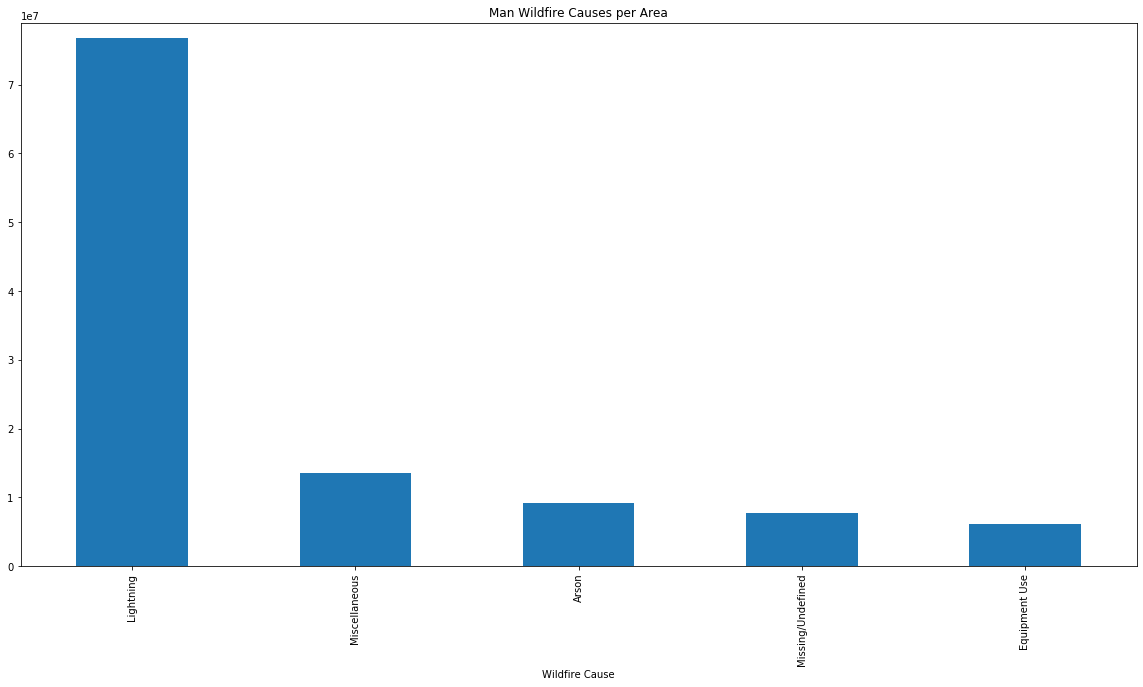

In [30]:
plt.figure(figsize=(20,10))
temp_fire.groupby('STAT_CAUSE_DESCR').FIRE_SIZE.sum().sort_values(ascending=False).head().plot(kind='bar').set_title('Man Wildfire Causes per Area')
plt.xlabel('Wildfire Cause')
plt.ylim([0,79000000]);

In [6]:
# evolution in time of the fire cases by cause

def plotyear(year):
    data = new_df[new_df['Year']==year]
    size = data.Count
    colors = data.STAT_CAUSE_DESCR.map({'Miscellaneous':'silver', 
                                        'Campfire':'palegreen', 
                                        'Arson':'coral', 
                                        'Debris Burning':'gray',
                                        'Equipment Use':'palegreen', 
                                        'Smoking':'palegreen', 
                                        'Railroad':'palegreen', 
                                        'Children':'palegreen', 
                                        'Structure':'palegreen',
                                        'Fireworks':'palegreen', 
                                        'Lightning':'cyan', 
                                        'Missing/Undefined':'silver', 
                                        'Powerline':'palegreen'})
    data.plot.scatter('current_av_temperature',
                      'FIRE_SIZE',
                     s=size,
                     c=colors,
                     linewidth=1,
                     edgecolors='k',
                     figsize=(20,10));
    
    plt.xlabel('Average Temperature')
    plt.ylabel('Size of Fire (Acres)')
    plt.axis(xmin=-5,xmax=24,ymin=0,ymax=700)

In [7]:
interact(plotyear,
         year=widgets.IntSlider(description='Year',
                                        min=new_df['Year'].min(),
                                        max=new_df['Year'].max(),
                                        step=1,
                                        value=new_df['Year'].min()));

# set labels and legends

interactive(children=(IntSlider(value=1992, description='Year', max=2013, min=1992), Output()), _dom_classes=(…

In [24]:
new_df

Year   STAT_CAUSE_DESCR  Count  FIRE_SIZE  current_av_temperature  \
0    1992              Arson  11153  23.962908                8.036319   
1    1992           Campfire   2570  10.479276               14.241684   
2    1992           Children   2913  17.470997               10.721066   
3    1992     Debris Burning  12726  12.116623                7.714247   
4    1992      Equipment Use   5630  24.183606               12.512860   
..    ...                ...    ...        ...                     ...   
281  2013  Missing/Undefined   3766  52.843882               14.325303   
282  2013          Powerline    588  12.116015               11.491197   
283  2013           Railroad    393   8.744224               12.536481   
284  2013            Smoking   1195   2.211096               11.800954   
285  2013          Structure    194   3.824227                9.702129   

     rel_temperature  
0           0.709693  
1           0.040815  
2           0.441100  
3           0.770135  
4           0.194698  
..               ...  
281         0.648449  
282         0.391026  
283         0.185190  
284         0.339751  
285         0.222954  

[286 rows x 6 columns]

In [49]:
# all reported causes of fire incidents

temp_fire['STAT_CAUSE_DESCR'].unique()

array(['Miscellaneous', 'Campfire', 'Arson', 'Debris Burning',
       'Equipment Use', 'Smoking', 'Railroad', 'Children', 'Structure',
       'Fireworks', 'Lightning', 'Missing/Undefined', 'Powerline'],
      dtype=object)

In [10]:
# shape of the final file.a final look.

temp_fire.shape

(1729614, 13)